# Nice plots of clusters

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
import torch

sys.path.append("./")
sys.path.append("../../")

from clustering.cluster import cluster_dataset, cluster_similarity_matrix, create_prototypes
from sklearn.preprocessing import StandardScaler

from representations.representations import calculate_pca, calculate_sarima, calculate_tsne
from similarities.similarities import calculate_similarity_matrix

In [2]:
representation = "pca"
similarity = "euclidean"
algorithm = "KMeans"
num_clusters=10
num_components=10
scale=False
start="2012-01-04"
end="2014-12-16"

In [3]:
from electricity.data import ElectricityDataSet

dataset_scaled = ElectricityDataSet(
    "electricity/data/electricity.npy",
    data_scaler=None,
    data_scale=True,
    start_date=start,
    end_date=end,
    include_time_covariates=False,
    predict_ahead=1,
    h_batch=0,
    one_hot_id=False,
    receptive_field=385,
    cluster_covariate=False,
    random_covariate=False,
    representation=None,
    similarity=None,
    num_clusters=10,
    num_components=None,
    algorithm="kmeans",
    cluster_dict=None,
)
dataset_unscaled = ElectricityDataSet(
    "electricity/data/electricity.npy",
    data_scaler=None,
    data_scale=False,
    start_date=start,
    end_date=end,
    include_time_covariates=False,
    predict_ahead=1,
    h_batch=0,
    one_hot_id=False,
    receptive_field=385,
    cluster_covariate=False,
    random_covariate=False,
    representation=None,
    similarity=None,
    num_clusters=10,
    num_components=None,
    algorithm="kmeans",
    cluster_dict=None,
)

Dimension of X :  torch.Size([370, 1, 25872])
Dimension of Y :  torch.Size([370, 1, 25872])
Dimension of X :  torch.Size([370, 1, 25872])
Dimension of Y :  torch.Size([370, 1, 25872])


In [4]:
dataset_scaled = dataset_scaled.X.squeeze().detach().numpy()
dataset_unscaled = dataset_unscaled.X.squeeze().detach().numpy()
dataset_scaled[1], dataset_unscaled[1], dataset_scaled.shape, dataset_unscaled.shape

(array([-0.5624817 , -0.7083016 , -0.72912884, ..., -0.39580527,
        -0.6458199 , -0.874978  ], dtype=float32),
 array([91.038, 86.06 , 85.349, ..., 96.728, 88.193, 80.37 ], dtype=float32),
 (370, 25872),
 (370, 25872))

# Representations

In [5]:
representations = {}
representations["pca_scaled"] = calculate_pca(dataset_scaled, num_components=num_components)
representations["pca_unscaled"] = calculate_pca(dataset_unscaled, num_components=num_components)
print("calculating tsne")
representations["tsne_scaled"] = calculate_tsne(dataset_scaled, num_components=num_components)
representations["tsne_unscaled"] = calculate_tsne(dataset_unscaled, num_components=num_components)
print("raw")
representations["raw"] = dataset_unscaled
print("Done")

Num components  10
Explained variance ratio: 0.9999818205833435
Num components  10
Explained variance ratio: 0.9995153546333313
calculating tsne
raw
Done


# Similarities

* Euclidean: pca, tsne, sarima
* Correlation: raw
* DTW: raw

Lets do pca + euclidean and raw + correlation as a starting point. Add more later.

In [6]:
sims = {}
sims["pca_ed_sim_scaled"] = calculate_similarity_matrix(representations["pca_scaled"], metric="euclidean", dist_or_sim="sim")
sims["pca_ed_sim_unscaled"] = calculate_similarity_matrix(representations["pca_unscaled"], metric="euclidean", dist_or_sim="sim")
sims["pca_ed_dist_scaled"] = calculate_similarity_matrix(representations["pca_scaled"], metric="euclidean", dist_or_sim="dist")
sims["pca_ed_dist_unscaled"] = calculate_similarity_matrix(representations["pca_unscaled"], metric="euclidean", dist_or_sim="dist")
sims["raw_corr_sim"] = calculate_similarity_matrix(representations["raw"], metric="correlation", dist_or_sim="sim")
sims["raw_corr_dist"] = calculate_similarity_matrix(representations["raw"], metric="correlation", dist_or_sim="dist")

In [7]:
print(num_clusters)
clusters, num_clusters = cluster_similarity_matrix(sims["raw_corr_dist"], algorithm="KMeans", num_clusters=num_clusters)
cluster_dist = {c: len(clusters[np.where(clusters == c)]) for c in range(num_clusters)}
for k, v in cluster_dist.items():
    print(f"{k:2} : {v}")
prototypes, _, _ = create_prototypes(clusters, dataset_scaled)
cluster_dict = {i: clusters[i] for i in range(len(clusters))}

10
 0 : 27
 1 : 144
 2 : 33
 3 : 35
 4 : 23
 5 : 21
 6 : 46
 7 : 14
 8 : 4
 9 : 23


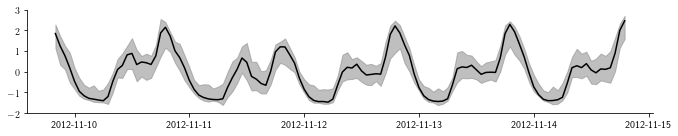

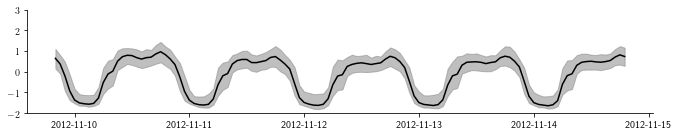

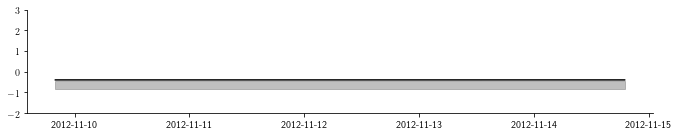

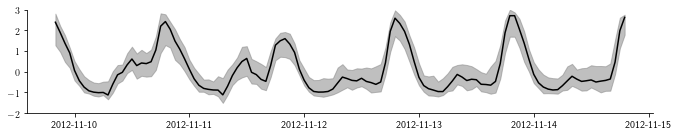

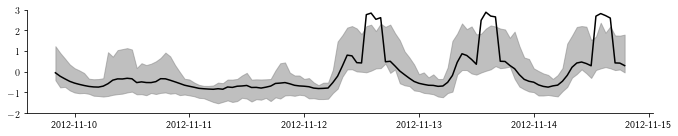

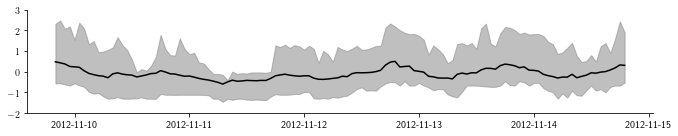

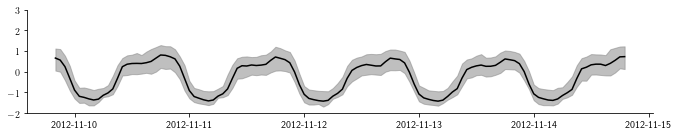

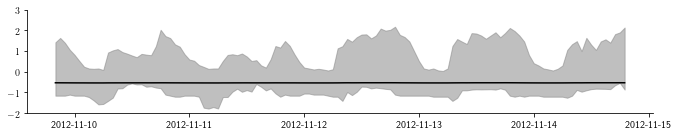

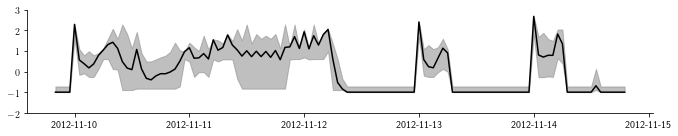

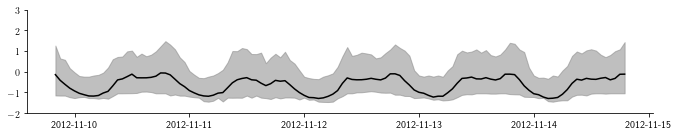

In [15]:
from matplotlib import rc
rc("text", usetex=True)
mystyle = {
    "axes.spines.left": True,
    "axes.spines.right": False,
    "axes.spines.bottom": True,
    "axes.spines.top": False,
    "axes.grid": False,
    "xtick.bottom": True,
    "ytick.left": True,
}
# for each cluster
length=120
date_range = pd.date_range(start=start, periods=dataset_scaled.shape[1], freq="H")
len_series = min([len(p) for p in prototypes.values()])
plot_index = np.random.randint(0, len_series - length)
size=4.77*2
height = 2
scale_plot = True
fill_area = True

with plt.style.context(mystyle):
    for c in set(cluster_dict.values()):
        # get the prototype
        p = prototypes[c]
        # get the ts
        members = {f"prot_{c}":p}
        for ts in cluster_dict.keys():
            #if ts == 10:
            #    break
            if cluster_dict[ts] == c:
                members[str(ts)] = dataset_unscaled[ts]
        df = pd.DataFrame(members)
        if scale_plot:
            df[df.columns] = StandardScaler().fit_transform(df[df.columns])
        df.index = date_range
        df = df[plot_index : plot_index + length]
        plt.figure(figsize=(size, height))
        if not fill_area:
            rgba_colors = np.zeros((len(df), 4))
            rgba_colors[0,3] = 1
            rgba_colors[1:,3] = 0.1
            df.plot(
                legend=False,
                color=rgba_colors,
                #title=f"Cluster {c}, size {len(df.columns)-1}",
                ylim=(-2,4.5)
            )
            plt.tight_layout()
            plt.savefig(f"cluster_all_{c}.pdf", bbox_inches="tight")
            plt.show()
        else:
            std = df.std(axis=1)
            #plt.figure(figsize=(size, height))
            plt.plot(df.index, df[f"prot_{c}"], c="black")
            plt.fill_between(df.index, df.quantile(0.1, axis=1, interpolation="nearest").values, df.quantile(0.9, axis=1, interpolation="nearest").values, color='grey', alpha=0.5)
            #plt.title(f"Cluster {c}, size {len(df.columns)-1}")
            plt.ylim((-2, 3))
            plt.tight_layout()
            plt.savefig(f"cluster_{c}.pdf", bbox_inches="tight")
            plt.show()

# Visualize the clustering

In [9]:
# PCA + t-SNE to get 2D representation of the samples
emb_scaled = calculate_tsne(dataset_scaled, num_components=2)
emb_unscaled = calculate_tsne(dataset_unscaled, num_components=2)

In [10]:
emb_scaled.shape

(370, 2)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


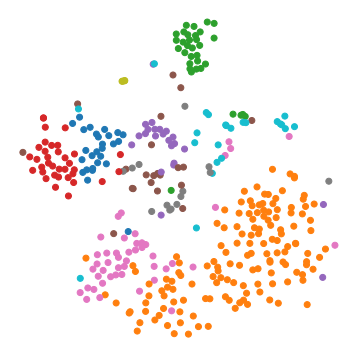

In [11]:
# Scatter plot
from matplotlib.collections import LineCollection
mystyle = {
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.bottom": False,
    "axes.spines.top": False,
    "axes.grid": False,
    "xtick.bottom": False,
    "ytick.left": False,
}
print(set(cluster_dict.values()))
with plt.style.context(mystyle):
    colors = [v for k, v in cluster_dict.items()]
    plt.figure(figsize=(4.77, 4.77))
    ax = plt.axes([0., 0., 1., 1.])
    plt.scatter(emb_scaled[:,0], emb_scaled[:,1], c = colors, cmap="tab10")
    plt.xticks([])
    plt.yticks([])

    # Display a graph of the partial correlations
    non_zero = (np.abs(np.triu(np.exp(-sims["raw_corr_dist"]), k=1)) > 0.91 )
    print(non_zero)

    # Plot the edges
    start_idx, end_idx = np.where(non_zero)
    segments = [[emb_scaled[start, :], emb_scaled[stop, :]] for start, stop in zip(start_idx, end_idx)]
    lc = LineCollection(segments, zorder=0)
    #ax.add_collection(lc)
    plt.tight_layout()
    plt.savefig(f"clustering.pdf", bbox_inches="tight")
    plt.show()